# Preliminaries

In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [2]:
from dissipationtheory.constants import ureg, qe, epsilon0
from dissipationtheory.dissipation4 import CantileverModel, SampleModel1, SampleModel2
from dissipationtheory.dissipation4 import CantileverModelJit, SampleModel1Jit, SampleModel2Jit
from dissipationtheory.dissipation4 import theta1norm_jit, gamma_perpendicular_jit, blds_perpendicular_jit

In [3]:
THIS = 'dissipation-theory--Study-34--'
figs = {}

# Set up the cantilever

In [4]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(75, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(35, 'nm'), 
    d = ureg.Quantity(38, 'nm'),
    z_c = ureg.Quantity(73, 'nm')
)

In [5]:
cantilever

cantilever

         resonance freq = 75.000 kHz
                        = 4.712e+05 rad/s
        spring constant = 2.800 N/m
     tip-sample voltage = 1.000 V
                 radius = 35.000 nm
                 height = 38.000 nm
  tip charge z location = 73.000 nm

# Set up the sample

Assume a fixed mobility of $\mu = 10^{-8} \: \mathrm{m}^2/\mathrm{V s}$, an ionic mobility.  As we vary the conductivity $\sigma$, we should vary the charge density $\rho$ to keep the mobility constant.  Pick a starting $\sigma$ and compute the associated charge density that achieves the above target mobility.

In [6]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
sigma = ureg.Quantity(1E-5, 'S/m')
rho = (sigma / (qe * mu)).to('1/m^3')

Set up the sample object.

In [7]:
sample1 = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(7300, 'nm'), # 100 times the sample-charge separation
    epsilon_s = ureg.Quantity(complex(20, -0.2), ''), 
    sigma = sigma,
    rho = rho,
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(73, 'nm')
)

Print out the sample parameters, making sure the mobility is correct.

In [8]:
sample1

cantilever

         resonance freq = 75.000 kHz
                        = 4.712e+05 rad/s
        spring constant = 2.800 N/m
     tip-sample voltage = 1.000 V
                 radius = 35.000 nm
                 height = 38.000 nm
  tip charge z location = 73.000 nm

semiconductor

             epsilon (real) = 20.000
             epsilon (imag) = -0.200
                  thickness = 7300.0 nm
               conductivity = 1.000e-05 S/m
             charge density = 6.242e+21 m^{-3}
           reference height = 7.300e+01 nm

         roll-off frequency = 1.129e+06 Hz
                   mobility = 1.000e-08 m^2/(V s)
         diffusion constant = 2.585e-10 m^2/s
               Debye length = 1.513e+01 nm
           diffusion length = 2.342e+01 nm
   effective epsilon (real) = 20.000
   effective epsilon (imag) = -2.597

dielectric

  epsilon (real) = 1000000.000
  epsilon (imag) = 0.000
       thickness = infinite

Create the jit sample object.

In [9]:
sample1_jit = SampleModel1Jit(**sample1.args())

# Loop over charge density

I am largely echoing the code from `Study 29` here, but with minor improvements.  Set up an array of modulation frequencies and an array of conductivities.

For code development, set

* `N_omega` = 10
* `N_sigma` = 10

To make paper-quality figures, rerun with

* `N_omega` = 100
* `N_sigma` = 200

In [10]:
N_omega = 100 # 10 or 100
N_sigma = 200 # 20 or 200

In [11]:
omega_m__array = ureg.Quantity(
    np.logspace(
        start=np.log10(1e1),
        stop=np.log10(1e8),
        num=N_omega), 'Hz')

In [12]:
sigma__array = ureg.Quantity(
    np.logspace(
        start=np.log10(1e-10),
        stop=np.log10(1),
        num=N_sigma), 'S/m')

Assume a fixed mobility of $\mu = 10^{-8} \: \mathrm{m}^2/\mathrm{V s}$, an ionic mobility.  As we vary $\sigma$, we should vary the charge density $\rho$ to keep the mobility constant.  Compute a corresponding charge density array.

In [13]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
rho__array = (sigma__array / (qe * mu)).to('1/m^3')

Get ready to run the simuations.

In [14]:
data = {}        # many simulations
data['01'] = {}  # the first simulation

Loop over conductivities, computing the BLDS spectrum and the friction.  Add to the data 

* a scaled BLDS frequency axis, $\Omega_{\mathrm{m}} \equiv (\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{m}})/\omega_0$ or `omega_m scaled`

* a scaled charge density axis, $\hat{\rho}_1 \equiv z_{\mathrm{c}}^2 / \lambda_{\mathrm{D}}^2$ or `rho scaled 1`

* a second scaled charge density axis, $\hat{\rho}_2 \equiv z_{\mathrm{c}}^2 / (\epsilon_{\mathrm{s}}^{\prime} \lambda_{\mathrm{D}}^2)$ or `rho scaled 2`

* a scaled frequency axis $\Omega_0 \equiv \omega_0/(\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{c}})$ or `omega_c scaled`

with

\begin{equation}
\lambda_{\mathrm{D}}^2 \equiv \frac{\epsilon_0 k_{\mathrm{B}} T}{e^2 \rho}
\end{equation}

the Debye length and $z_{\mathrm{c}}$ the sample-to-tip-charge separation.


In [15]:
def calculate(sample1_jit, omega_m, rho, sigma):
    
    data = {}
    for rho_, sigma_ in zip(rho, sigma):

        sample1_jit.rho = rho_.to('1/m^3').magnitude
        sample1_jit.sigma = sigma_.to('S/m').magnitude
    
        gamma = gamma_perpendicular_jit(theta1norm_jit, sample1_jit).to('pN s/m')
        f_BLDS = blds_perpendicular_jit(theta1norm_jit, sample1_jit, omega_m).to('Hz')
        
        ep = sample1_jit.epsilon_s.real   
        z_c = ureg.Quantity(sample1_jit.cantilever.z_c, 'm')
        LD = ureg.Quantity(sample1_jit.LD, 'm')
        rho = ureg.Quantity(sample1_jit.rho, '1/m^3')
        omega_0 = (ureg.Quantity(sample1_jit.sigma, 'S/m')/epsilon0).to('Hz')
        omega_c = ureg.Quantity(sample1_jit.cantilever.omega_c, 'Hz')
    
        data[str(sigma_.to('S/m').magnitude)] = {
            'sample': sample1_jit,
            'omega_0': omega_0,
            'omega_m': omega_m,
            'omega_m scaled': ((ep * omega_m)/omega_0).to('').magnitude,
            'f_BLDS': f_BLDS, 
            'gamma': gamma,
            'sigma': ureg.Quantity(sample1_jit.sigma, 'S/m'),
            'z_c': z_c,
            'LD': LD,
            'rho': rho,
            'rho scaled 1': (z_c**2/(     LD**2)).to('').magnitude,
            'rho scaled 2': (z_c**2/(ep * LD**2)).to('').magnitude,
            'omega_c': omega_c,
            'omega_c scaled': (omega_0/(ep * omega_c)).to('').magnitude}

    return data

In [16]:
%%time

data['01'] = calculate(sample1_jit, omega_m__array, rho__array, sigma__array)

CPU times: user 57.2 s, sys: 971 ms, total: 58.2 s
Wall time: 1min 3s


# Plot the BLDS spectrum versus charge density and scaled charge density

A helper function for plotting the BLDS spectrum.

In [17]:
def plotBLDS(data):

    rho = np.zeros(len(data))    
    for index, key in enumerate(data.keys()):
        
        rho[index] = data[key]['rho'].to('1/cm^3').magnitude

    # colormap = plt.cm.jet
    colormap = plt.cm.magma_r
    color_list = [colormap(i) for i in np.linspace(0, 1, len(data))]

    normalized_colors = mcolors.LogNorm(vmin=min(rho), vmax=max(rho))
    scalar_mappable = cm.ScalarMappable(norm=normalized_colors, cmap=colormap)
    scalar_mappable.set_array(len(color_list))
    
    fig, ax = plt.subplots(figsize=(4.5, 3))
    for index, key in enumerate(data.keys()):
        
        with plt.style.context('seaborn-v0_8'):
            plt.semilogx(
                data[key]['omega_m'].to('Hz').magnitude,
                np.abs(data[key]['f_BLDS'].sum(axis=1).to('Hz').magnitude),
                '-',
                color=color_list[index])

    # color bar
    clb=plt.colorbar(scalar_mappable, ax=ax)
    clb.ax.set_title(r'$\rho \: [\mathrm{cm}^{-3}]$', fontsize=12)
    
    plt.ylabel('|$\Delta f_{\mathrm{BLDS}}$| [Hz]')
    plt.xlabel('modulation freq. $\omega_{\mathrm{m}}$ [rad/s]')
    plt.tight_layout()
    plt.show()
    
    return fig

Plot every 10th spectrum.

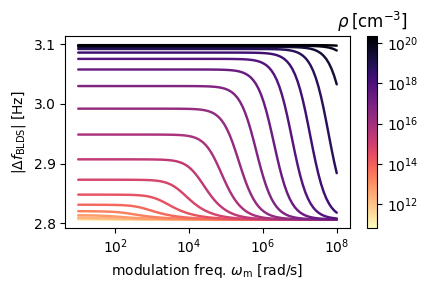

In [18]:
data['01-short'] = {}
for key in list(data['01'].keys())[::10]:
    data['01-short'][key] = data['01'][key]
    
figs['01a'] = plotBLDS(data['01-short'])

A helper function that plots the data versus the *scaled* modulation frequency $\Omega_{\mathrm{m}}$.  Place a dotted vertical line at $\Omega_{\mathrm{m}} = 1$.

In [50]:
def plotBLDSscaled(data):

    rho = np.zeros(len(data))    
    for index, key in enumerate(data.keys()):
        
        rho[index] = data[key]['rho'].to('1/cm^3').magnitude

    # colormap = plt.cm.jet
    colormap = plt.cm.magma_r
    color_list = [colormap(i) for i in np.linspace(0, 1, len(data))]

    normalized_colors = mcolors.LogNorm(vmin=min(rho), vmax=max(rho))
    scalar_mappable = cm.ScalarMappable(norm=normalized_colors, cmap=colormap)
    scalar_mappable.set_array(len(color_list))
    
    fig, ax = plt.subplots(figsize=(4.5, 3))
    for index, key in enumerate(data.keys()):
        
        with plt.style.context('seaborn-v0_8'):
            plt.semilogx(
                data[key]['omega_m scaled'],
                np.abs(data[key]['f_BLDS'].sum(axis=1).to('Hz').magnitude),
                '-',
                color=color_list[index])

    # color bar
    clb=plt.colorbar(scalar_mappable, ax=ax)
    clb.ax.set_title(r'$\rho \: [\mathrm{cm}^{-3}]$', fontsize=12)
    
    # vertical line
    plt.vlines(1.0, 2.8, 3.1, colors='tab:gray', linestyles='dashed')
    
    plt.xlim(1e-2,1e2)
    plt.ylabel('|$\Delta f_{\mathrm{BLDS}}$| [Hz]')
    plt.xlabel('scaled modulation freq. $\Omega_{\mathrm{m}} = '
               '(\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{m}})/\omega_0$')
    plt.tight_layout()
    plt.show()
    
    return fig

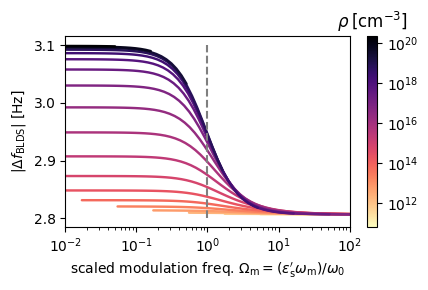

In [51]:
figs['01b'] = plotBLDSscaled(data['01-short'])

# Plot the zero-frequency BLDS point versus charge density

A helpful plotting function.

In [57]:
def plotBLDS0scaled(data):

    # generate arrays for plotting
    
    rho = np.zeros(len(data))
    rho_scaled = np.zeros(len(data)) 
    BLDS0 = np.zeros(len(data)) 
    
    for index, key in enumerate(data.keys()):
        
        rho[index] = data[key]['rho'].to('1/cm^3').magnitude
        rho_scaled[index] = data[key]['rho scaled 2']
        BLDS0[index] = np.abs(data[key]['f_BLDS']).sum(axis=1)[0].to('Hz').magnitude
    
    # Define functions to convert from  $\hat{\rho}$ to $\rho$ and back again
    
    rho0 = (rho/rho_scaled)[0]
    
    def fwd(x):
        return x*rho0

    def rev(rho):
        return rho/rho0   
    
    # now plot
    
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.0))
    
    with plt.style.context('seaborn-v0_8'):
        ax.semilogx(rho_scaled, BLDS0)

    axT = ax.secondary_xaxis("top", functions=(fwd,rev))
        
    plt.vlines(1.0, 2.8, 3.1, colors='tab:gray', linestyles='dashed')        
    ax.set_ylabel(r'|$\Delta f_{\mathrm{BLDS}}(\omega_{\mathrm{m}}=0)$| [Hz]')
    ax.set_xlabel(r'scaled charge density $\hat{\rho} = z_{\mathrm{c}}^2/(\epsilon_{\mathrm{s}}^{\prime} \lambda_{\mathrm{D}})$')
    axT.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    
    plt.grid()
    plt.tight_layout()
    
    return fig

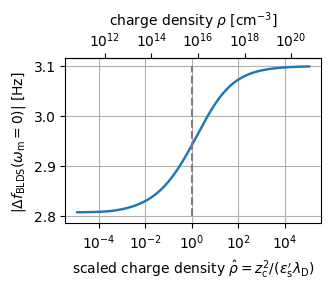

In [58]:
figs['02'] = plotBLDS0scaled(data['01'])

# Scaled frequency versus conductivity and dielectric constant

What range of conductivities are measurable in a BLDS experiment?  The BLDS signal depends on the scaled frequency 

\begin{equation}
\Omega_{\mathrm{m}} = \frac{\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{m}}}{\omega_0}
 = \frac{\epsilon_{\mathrm{s}}^{\prime} \epsilon_0}{\sigma} \times \omega_{\mathrm{m}}
\end{equation}

As $\omega_{\mathrm{m}}$ is increased, the BLDS spectrum begins to roll off when $\Omega_{\mathrm{m}} = 1$.  At $\Omega_{\mathrm{m}} = 1$,

\begin{equation}
\sigma_{\mathrm{m}} = \epsilon_{\mathrm{s}}^{\prime} \epsilon_0 \omega_{\mathrm{m}}.
\end{equation}

This is the conductivity required to get a roll-off frequency at a given $\omega_{\mathrm{m}}$. In the BLDS experiment, we can observed frequencies over a six decade range, from $\omega_{\mathrm{m}}^{\mathrm{lower}} = 2 \pi \times 3 \: \mathrm{Hz}$ to $\omega_{\mathrm{m}}^{\mathrm{upper}} = 2 \pi \times 3 \, \mathrm{MHz}$. This range sets the range of measurable roll-off frequencies.  This constraint, the sample dielectric constant $\epsilon_{\mathrm{s}}^{\prime} \epsilon_0$, and the above equation determine the range of conductivity $\sigma$ that can be inferred from the BLDS spectrum.

In [23]:
omega0__array = 2 * np.pi * ureg.Quantity(
    np.logspace(start=np.log10(3), stop=np.log10(3e6), num=51), 'Hz')

The associated frequencies are

In [24]:
f0__array = omega0__array / (2 * np.pi)

Make an array of representative dielectric constants.  At each dielectric constant, compute an array of measurable conductivities.

In [25]:
epsilon_sr__array = np.array([1.0, 3.0, 10, 30, 100])

Make the plot wide so we get a major grid point every decade on the $x$ axis.

In [26]:
def plot_measurable_sigma(f0__array, epsilon_sr__array):

    sigma__dict = {}

    for index, epsilon_sr in enumerate(epsilon_sr__array):
        sigma__dict[index] = (epsilon_sr * epsilon0 * omega0__array).to('S/cm').magnitude

    with plt.style.context('seaborn-v0_8-dark'):        
        
        fig, ax = plt.subplots(1, 1, figsize=(5.0, 3.00))

        for index, epsilon_sr in enumerate(epsilon_sr__array):
            ax.loglog(sigma__dict[index],
                      f0__array.to('Hz').magnitude,
                      label='{:0.0f}'.format(epsilon_sr)) 

    plt.ylabel('BLDS spectrum roll-off freq. [Hz]')
    plt.xlabel('sample conductivity $\sigma$ [S/cm]')
    
    plt.legend(title=r'$\epsilon_{\mathrm{s}}^{\prime}$', facecolor='white', edgecolor='white')
    plt.grid(which='major')
    
    plt.tight_layout()
    
    return fig

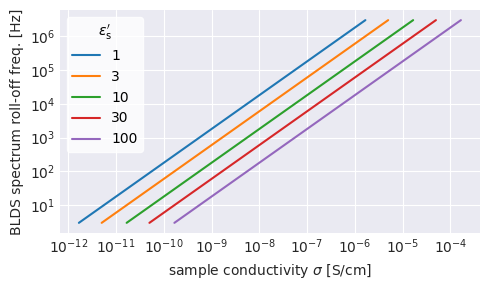

In [27]:
figs['04'] = plot_measurable_sigma(f0__array, epsilon_sr__array)

At higher dielectric constant, we need a comparatively higher conductivity to achieve the same roll-off frequency.

# Plot the friction

A function to plot the friction.

In [54]:
def plotfrictionscaled(data):

    # generate arrays for plotting
    
    rho = np.zeros(len(data))
    omega_c_scaled = np.zeros(len(data)) 
    gamma = np.zeros(len(data)) 
    
    for index, key in enumerate(data.keys()):
        
        rho[index] = data[key]['rho'].to('1/cm^3').magnitude
        omega_c_scaled[index] = data[key]['omega_c scaled']
        gamma[index] = data[key]['gamma'].sum(axis=0).to('pN s/m').magnitude
    
    # define functions to convert from omega_c_scale to rho and back again
    
    scale_factor = (rho/omega_c_scaled)[0]
    
    def fwd(omega_c_scaled):
        return omega_c_scaled * scale_factor

    def rev(rho):
        return rho / scale_factor
    
    # now plot
    
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.0))
    
    with plt.style.context('seaborn-v0_8'):
        ax.semilogx(omega_c_scaled, gamma)

    axT = ax.secondary_xaxis("top", functions=(fwd,rev))
        
    plt.vlines(1.0, 0, 17, colors='tab:gray', linestyles='dashed')        
    ax.set_ylabel(r'friction $\gamma_{\perp}$ [pN s/m]')
    ax.set_xlabel(r'scaled frequency $\Omega_0 = \omega_0/(\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{c}})$')
    axT.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    
    plt.grid()
    plt.tight_layout()
    
    return fig

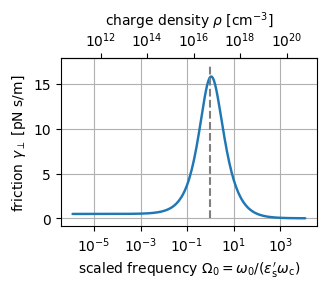

In [55]:
figs['05'] = plotfrictionscaled(data['01'])

# Plot friction for various dielectric constant imaginary parts

We need to carry out multiple simulations.  Start with the `sample1_jit` object above and tweak the imaginary part of the dielectric constant.

In [30]:
sample1_jit.print()

cantilever
        cantilever freq =  75000.0 Hz
                        =  471238.89803846896 rad/s
        spring constant =  2.8 N/m
     tip-sample voltage =  1.0 V
                 radius =  3.5e-08 m
                 height =  3.8e-08 m
  tip charge z location =  7.3e-08 m

semiconductor
          epsilon (real) =  20.0
          epsilon (imag) =  -0.2
               thickness =  7.3e-06 m
            conductivity =  1.0 S/m
          charge density =  6.241509090043338e+26 m^{{-3}}
        reference height =  7.3e-08 m
 
      roll-off frequency =  112940906737.30191 Hz
                mobility =  9.999999999999999e-09 m^2/(V s)
      diffusion constant =  2.585199985097773e-10 m^2/s
            Debye length =  4.7843334124727804e-11 m
        diffusion length =  2.3422136438546186e-08 m
effective epsilon (real) =  20.0
effective epsilon (imag) =  -239668.24779363134

dielectric
 epsilon (real) =  1000000.0
 epsilon (imag) =  0.0
      thickness = infinite


Create three data sets, each having a different value of the imaginary part of the dielectric constant.  Remember to reset the dielectric constant at the end.

In [31]:
%%time

for key, epsilon_s in zip(['02a', '02b', '02c', '02d'], [10-0.02j, 10-0.2j, 10-0.5j, 10-1j]):
    
    sample1.epsilon_s = ureg.Quantity(epsilon_s, '')
    sample1_jit = SampleModel1Jit(**sample1.args())

    data[key] = calculate(sample1_jit, omega_m__array, rho__array, sigma__array)

sample1.epsilon_s = ureg.Quantity(complex(20, -0.2), '') # reset it
sample1_jit = SampleModel1Jit(**sample1.args())          # reset it

CPU times: user 3min 50s, sys: 4.14 s, total: 3min 54s
Wall time: 4min 17s


Make a plotting function that handles multiple datasets.  Create two helper functions.  The first helper function takes a floating point number and turns it into a formatted LaTeX-style string for plotting, with a nicely formatted exponent.

In [32]:
def latex_float(f):
    float_str = "{0:.1e}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"${0} \times 10^{{{1}}}$".format(base, int(exponent))
    else:
        return float_str

Example function call.

In [33]:
latex_float(3e-7)

'$3.0 \\times 10^{-7}$'

The second function gets the global min and max over a subset of data.  For the `dataset='f_BLDS'` we are interested in plotting the absolute value of the data, so extract the min and max of the *absolute value* of the data.  Searching for the min and max of the absolute value of the data will work for `dataset='gamma'` too.

In [34]:
def dataminmax(data, datakeys, dataset, dataunit, sumaxis):
    
    min_array = np.zeros(len(datakeys))
    max_array = np.zeros(len(datakeys))
    
    for index, datakey in enumerate(datakeys):
        
        min_array[index] = np.array(
            [np.abs(data[datakey][key][dataset].sum(axis=sumaxis).to(dataunit).magnitude).min()
             for key in data[datakey].keys()]).min()
        
        max_array[index] = np.array(
            [np.abs(data[datakey][key][dataset].sum(axis=sumaxis).to(dataunit).magnitude).max()
             for key in data[datakey].keys()]).max()
    
    return (min_array.min(), max_array.max())

Three example function calls.

In [35]:
dataminmax(data, ['01'], 'f_BLDS', 'Hz', 1)

(2.8066986874500905, 3.0990670713230406)

In [36]:
dataminmax(data, ['02a', '02b', '02c', '02d'], 'gamma', 'pN s/m', 0)

(0.004206187143892618, 28.110800379614673)

Finally, a plotting function.

In [37]:
def plotmultiplefrictionscaled(data, datakeys, variables, variables_label):

    # create plot

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.25))
    
    for dataindex, datakey in enumerate(datakeys):
    
        # generate arrays for plotting

        rho = np.zeros(len(data[datakey]))
        omega_c_scaled = np.zeros(len(data[datakey])) 
        gamma = np.zeros(len(data[datakey])) 

        for index, key in enumerate(data[datakey].keys()):

            rho[index] = data[datakey][key]['rho'].to('1/cm^3').magnitude
            omega_c_scaled[index] = data[datakey][key]['omega_c scaled']
            gamma[index] = data[datakey][key]['gamma'].sum(axis=0).to('pN s/m').magnitude

        # define functions to convert from omega_c_scale to rho and back again

        scale_factor = (rho/omega_c_scaled)[0]

        def fwd(omega_c_scaled):
            return omega_c_scaled * scale_factor

        def rev(rho):
            return rho / scale_factor
    
        with plt.style.context('seaborn-v0_8'):
            ax.semilogx(omega_c_scaled, gamma, label=latex_float(variables[dataindex]))

    axT = ax.secondary_xaxis("top", functions=(fwd,rev))
    
    datamin, datamax = dataminmax(data, datakeys, 'gamma', 'pN s/m', 0)
    plt.vlines(1.0, datamin, 1.10 * datamax, colors='tab:gray', linestyles='dashed') 
    
    ax.set_ylabel(r'friction $\gamma_{\perp}$ [pN s/m]')
    ax.set_xlabel(r'scaled frequency $\Omega_0 = \omega_0/(\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{c}})$')
    axT.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    
    plt.grid()
    plt.legend(fontsize=8,
        title_fontsize=9,
        title=variables_label,
        facecolor='white',
        edgecolor='white')
    
    plt.tight_layout()
    
    return fig

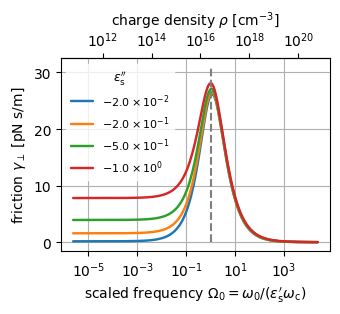

In [38]:
figs['06'] = plotmultiplefrictionscaled(data=data, 
    datakeys=['02a', '02b', '02c', '02d'],
    variables=[-0.02, -0.2, -0.5, -1],
    variables_label=r'$\epsilon_{\mathrm{s}}^{\prime\prime}$')

# Plot friction for various mobilities

Create three data sets, each having a different value of the mobility.  Remember to recompute the conductivity after changing the mobility.

In [39]:
%%time

for key, mu in zip(
    ['03a', '03b', '03c', '03d'],
    [ureg.Quantity(val, 'cm^2/(V s)') for val in [1e-6, 1e-4, 1e-3, 1e-2]]):
    
    rho__array = (sigma__array / (qe * mu)).to('1/m^3')
    data[key] = calculate(sample1_jit, omega_m__array, rho__array, sigma__array)

CPU times: user 3min 45s, sys: 4.54 s, total: 3min 49s
Wall time: 4min 16s


In [40]:
dataminmax(data, ['03a', '03b', '03c', '03d'], 'gamma', 'pN s/m', 0)

(0.004576086899139449, 24.44766096294189)

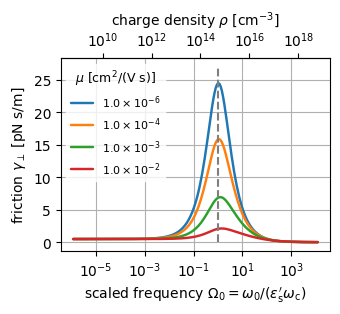

In [41]:
figs['07'] = plotmultiplefrictionscaled(data=data, 
    datakeys=['03a', '03b', '03c', '03d'],
    variables=[1e-6, 1e-4, 1e-3, 1e-2],
    variables_label=r'$\mu$ [cm$^2$/(V s)]')

::: {.content-hidden when-format="html"}

# Save the figures

In [59]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

:::

::: {.content-hidden when-format="html"}

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-34.ipynb 

Other useful information about this notebook:

- Filename: `dissipation-theory--Study-34.ipynb`
- Continued from: `dissipation-theory--Study-25.ipynb` and `dissipation-theory--Study-29.ipynb`
- Continued to: ---

:::